We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [11]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os

BATCH_SIZE = 1
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
ANGLES = 16
#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class ScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,ZONES))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:,:]
                y_train[j,:] = f['/labels'].value
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train
class LegScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan",batch_size=BATCH_SIZE):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
        self.batch_size = batch_size
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((self.batch_size,ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
        y_train = np.zeros((self.batch_size,1))
        s_weights = np.zeros((self.batch_size))
        j=0
        for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT*3//5,:]
                r_leg = [7,8,9,10,11,12,13,14,15]
                l_leg = [13,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                print("Would have posted{}".format(r_y))
                #l_y = np.amax(f['/labels'].value[l_leg])
                y_train[j,:] = r_y
                s_weights[j] = np.squeeze(r_y + (-1 * r_y + 1)*2)
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train,s_weights



In [12]:
from twilio.rest import Client
import configparser
from keras.callbacks import Callback

class SMSNotifier(Callback):
    def on_epoch_end(self,epoch,logs=None):
        #Execute every other epoch
        if epoch % 2 == 0:
            #Get config credentials
            config = configparser.ConfigParser()
            config.read('twilio.conf')
            account_sid = config['DEFAULT']['AccountID']
            auth_token = config['DEFAULT']['AuthToken']
            #Get client
            client = Client(account_sid, auth_token)
            #Create message
            if logs is not None:
                message = "Epoch {} complete. Loss: {} Val_loss: {} ".format(epoch,
                                                                             logs.get('loss'),
                                                                             logs.get('val_loss'))
            else:
                message = "Epoch {} complete. No loss data available.".format(epoch)
            #Sendmessage
            message = client.messages.create(
                to="+16178884129", 
                from_="+18572142288",
                body=message)
        else:
            pass

In [58]:
from matplotlib import pyplot as plt

#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = 50 #(sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
#Initialize validation sequencer

choices = np.random.randint(870,size=10)




Initializing generators...


Would have posted1.0
Values for 192
[[ 1.  0.  0.  0.  1.  0.  0.  0.  0.]]
[ 1.]
Would have posted1.0
Values for 359
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.]]
[ 1.]
Would have posted1.0
Values for 9
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.]]
[ 1.]
Would have posted0.0
Values for 0
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[ 2.]


IndexError: index 3 is out of bounds for axis 0 with size 3

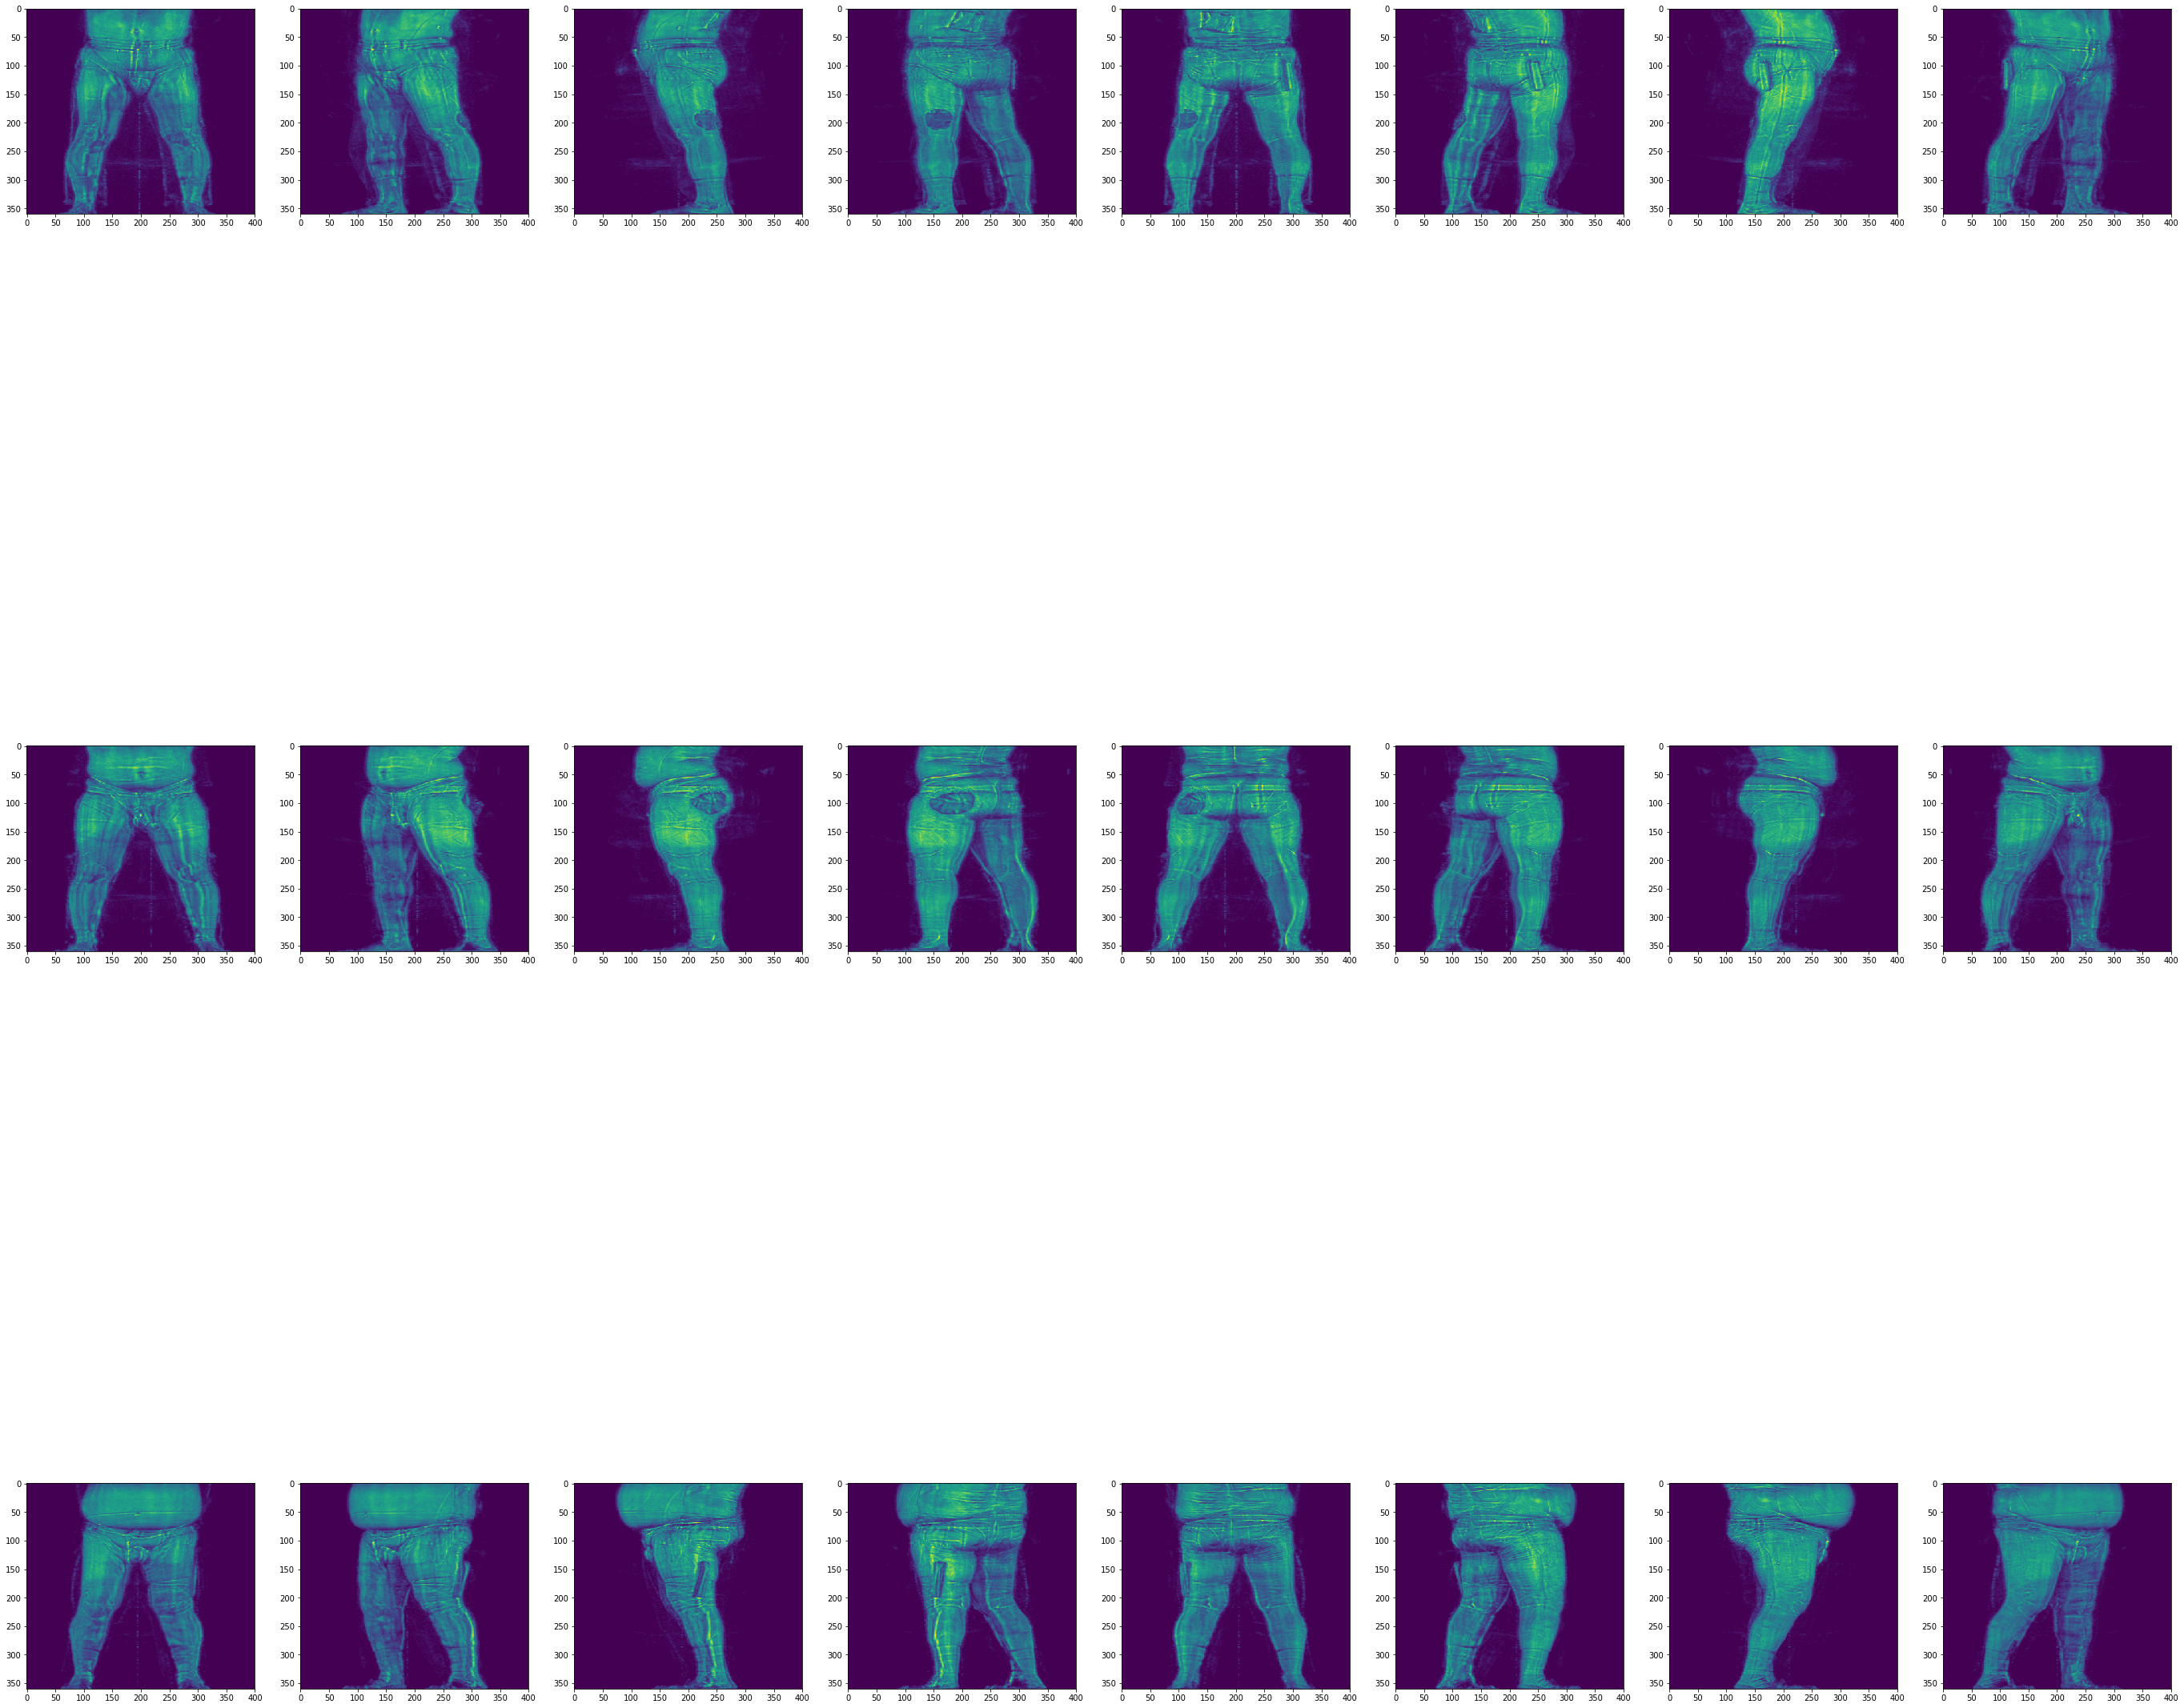

In [60]:
% matplotlib inline
fig,axes = plt.subplots(3,8,figsize = (48,48))
i = 0 
for c in [192,359,9,0,1]:
    X,y,w = train_seq.__getitem__(c)
    print("Values for {}".format(c))
    print(y)
    print(w)
    j=0
    for a in np.arange(0,16,16//8):
        axes[i,j].imshow(np.flipud(X[0,a,:,:,0].transpose()))#, cmap = 'viridis')
        j += 1
    i += 1

In [3]:
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

def weighted_binary_crossentropy(y_true, y_pred):
    x = 0.18 #Approximate percentage of positives in each of the 17 zones
    POS_ADJ = 0.5/x
    NEG_ADJ = 0.5/(1-x)
    n_values = BATCH_SIZE
    elems = (tf.unstack(y_true,num=n_values,axis=0)) 
    adj = tf.map_fn(lambda x:tuple([tf.cond(tf.equal(x[i],1.),lambda:POS_ADJ,lambda: NEG_ADJ) for i in range(n_values)]),
                    elems, 
                    dtype = tuple([tf.float32 for i in range(n_values)]) )
    adj = tf.stack(adj,axis=0)
    return K.mean(tf.multiply(adj,K.binary_crossentropy(y_true,y_pred)),axis=-1)

In [13]:
#Build pre-trained V2 model
import numpy as np
from keras.layers import Input,Flatten,Dense,Concatenate,Dropout,concatenate,GlobalMaxPool2D,GlobalAveragePooling1D
from keras.models import Model
from datetime import datetime
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam,Adadelta,SGD
from keras.metrics import binary_accuracy
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.losses import binary_crossentropy
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers.core import Lambda
import tensorflow as tf
from keras import backend as K

#K.set_learning_phase(1)

def ToRGB(x):
    max_v = tf.reduce_max(x)
    min_v = tf.reduce_min(x)
    max_rgb = tf.constant(255,dtype=x.dtype)
    x = tf.floordiv(tf.multiply(tf.subtract(x,min_v),max_rgb),tf.subtract(max_v,min_v))
    return x
def ToGreyScale(x):
    #Divide RGB into 3
   # scalar = tf.constant(3,dtype=x.dtype)
    #x = tf.floordiv(x,scalar)
    shape = x.get_shape()
    #assume channel_last
    mult = [[1 for d in shape[:-1]],[3]]
    mult = [val for sublist in mult for val in sublist]
    return tf.tile(x,mult)
def ToNewShape(x):
    ndim = len(x.shape)
    if ndim == 5:
        return tf.reverse(tf.transpose(x,[0,1,3,2,4]),[-3])
    elif ndim == 4:
        return tf.reverse(tf.transpose(x,[0,2,1,3]),[-3])
    else:
        raise ValueError("Unexpected number of dims!")

def getSingleLegModel(lstm_dim=100):
    #Single model image
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
    
    #preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    #Load resnet
    incep = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT*3//5,FINAL_WIDTH,3),
                          pooling='max')
    for l in incep.layers:
        l.trainable=False

    #Take off top
    reduced_net = Model(incep.input,incep.get_layer('mixed5').output)
    print(reduced_net.uses_learning_phase)
    output = reduced_net(input_img_pp)
    output = Flatten()(output)
    dropout = Dropout(0.5)(output)
    dense = Dense(100)(dropout)
    dense = Dense(1,activation='sigmoid',use_bias=False)(dense)
    intermediate_model = Model(input_img,dense)
    print(intermediate_model.uses_learning_phase)
    #Time distributed model
    input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    sequenced_model = TimeDistributed(intermediate_model)(input_scan)
    print(sequenced_model._uses_learning_phase)
    sequenced_model._uses_learning_phase = True
    #One GRU layer for now
    #gru = GRU(lstm_dim,dropout=0.5,use_bias=False)(sequenced_model)
    #Finally, 1 dense layers
    out = GlobalAveragePooling1D()(sequenced_model)
    #complete model
    model = Model(input_scan,out)
    print(model.uses_learning_phase)
    try:
        return model#Model(input_scan, out)
    finally:
        del intermediate_model,sequenced_model,incep
        



In [14]:
#Tensorboard wrapper #https://github.com/fchollet/keras/issues/3358
class TensorBoardWrapper(TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super().__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps     # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        X_val,y_val,w_val = None, None, None
        for s in range(self.nb_steps):
            X, y, w = self.batch_gen.__getitem__(s)
            if X_val is None and y_val is None and w_val is None:
                X_val = np.zeros((self.nb_steps * X.shape[0], *X.shape[1:]))
                y_val = np.zeros((self.nb_steps * y.shape[0], *y.shape[1:]))
                w_val = np.zeros((self.nb_steps * w.shape[0]))
            X_val[s * X.shape[0]:(s + 1) * X.shape[0]] = X
            y_val[s * y.shape[0]:(s + 1) * y.shape[0]] = y
            w_val[s * w.shape[0]:(s + 1) * w.shape[0]] = w
        self.validation_data = (X_val,y_val,w_val,0)
        return super().on_epoch_end(epoch, logs)

In [15]:

average_model = getSingleLegModel()


True
True
False
True


In [6]:
for l in average_model.layers:
    print(l.name, l.trainable)

average_model.layers[1].get_config()

input_3 False
time_distributed_1 True
global_average_pooling1d_1 True


{'layer': {'class_name': 'Model',
  'config': {'input_layers': [['input_1', 0, 0]],
   'layers': [{'class_name': 'InputLayer',
     'config': {'batch_input_shape': (None, 400, 300, 1),
      'dtype': 'float32',
      'name': 'input_1',
      'sparse': False},
     'inbound_nodes': [],
     'name': 'input_1'},
    {'class_name': 'Lambda',
     'config': {'arguments': {},
      'function': ('ã\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x05\x00\x00\x00C\x00\x00\x00sp\x00\x00\x00t\x00\x00j\x01\x00|\x00\x00\x83\x01\x00}\x01\x00t\x00\x00j\x02\x00|\x00\x00\x83\x01\x00}\x02\x00t\x00\x00j\x03\x00d\x01\x00d\x02\x00|\x00\x00j\x04\x00\x83\x01\x01}\x03\x00t\x00\x00j\x05\x00t\x00\x00j\x06\x00t\x00\x00j\x07\x00|\x00\x00|\x02\x00\x83\x02\x00|\x03\x00\x83\x02\x00t\x00\x00j\x07\x00|\x01\x00|\x02\x00\x83\x02\x00\x83\x02\x00}\x00\x00|\x00\x00S)\x03Néÿ\x00\x00\x00Ú\x05dtype)\x08Ú\x02tfÚ\nreduce_maxÚ\nreduce_minÚ\x08constantr\x02\x00\x00\x00Ú\x08floordivÚ\x08multiplyÚ\x08subtract)\x04Ú\x01xÚ\x05max_vÚ\

In [9]:
recurrent_model.load_weights("check_points/ScanModel_09-1.14.hdf5")

In [16]:
from keras.models import load_model
description = "Average_layer5"
#adad = Adadelta()
#print("Loading weights")
#average_model.load_weights("check_points/AverageModel_00-11.94.hdf5")
#adam = Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
sgd = SGD(lr = 0.001,momentum = 0.25,nesterov=True)
average_model.compile(optimizer=sgd,
                          metrics=[binary_accuracy],
                         loss= binary_crossentropy,)


#Model checkpoint
x = datetime.today()
check_point_dir = 'check_points/'
if not os.path.isdir(check_point_dir):
    os.makedirs(check_point_dir)    
chkpt = ModelCheckpoint(os.path.join(check_point_dir,"AverageModel_{epoch:02d}-{val_loss:.2f}.hdf5"),
                       monitor='val_loss',
                       verbose=1,
                       save_best_only=True)
#Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=4,
                             verbose=1,
                             min_lr=0.0001,
                             cooldown = 5)
#Notifications
notify = SMSNotifier()

#Early stopping callback
estop = EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=25)

#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = 25 #(sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
#Initialize validation sequencer
mode = "val_scan"
num_batches_val = 25 # (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)

#Tensorboard
stamp = "Average_Model_Train_SGD_0.001"
tensorboard = TensorBoardWrapper(val_seq,nb_steps=1,log_dir="logs/{}".format(stamp),histogram_freq=1,batch_size=2,
                          write_grads=False,write_images=False,write_graph=False)
    

print("Beginning training...")
#recurrent_model.load_weights('check_points/2017_10_3_17_ScanModel_01-1.29.hdf5')

hist= average_model.fit_generator(train_seq,
                                   steps_per_epoch=20,#num_batches_train,
                                   epochs=500,
                                   validation_data=val_seq,
                                    validation_steps = 20,# num_batches_val,
                                   callbacks=[chkpt,tensorboard,notify,estop,reduce_lr],
                                  use_multiprocessing = True,workers=4)


Initializing generators...
Beginning training...
Epoch 1/500
Would have posted0.0
Would have posted1.0
Would have posted0.0
Would have posted1.0
Would have posted1.0
Would have posted0.0
Would have posted0.0
Would have posted1.0
Would have posted1.0
Would have posted0.0
Would have posted1.0
Would have posted0.0


ValueError: Error when checking target: expected global_average_pooling1d_3 to have shape (None, 1) but got array with shape (1, 9)

In [1]:
#Test modelchanges
sess = tf.InteractiveSession()
slm = getSingleLegModel()
result = slm.predict(X)

print(result.shape)



NameError: name 'tf' is not defined

In [ ]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(result[0,1,:,:,:])#, cmap = 'viridis')


In [ ]:
#Test how many positive samples
import pickle
labels = hfuncs.GetLabelsDict(r'stage1_labels.csv')
filename = "data_separated.pickle"
with open(filename,"rb") as f:
   save = pickle.load(f)
   K_test= save['K_test']
   K_val = save['K_val']
   K_train = save['K_train']
s = 0
pos = 0
for k in K_train:
    k_clean = k.replace("DHSData/","").replace(".a3daps","")
    if k_clean in labels.keys():
        label = np.array(labels[k_clean])
        val = np.amax(label[[12,14,13,15]])
        if val == 1:
            s += 1
            pos += 1
        else:
            s += 1
print("total={},pos={}".format(s,pos))